In [192]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

### Gradient boost guided example

Having walked through gradient boost by hand, now let's try it with SKlearn.  We'll still use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

In [193]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

In [194]:
df.head()

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0


In [195]:
df.shape

(8147, 13)

#### VARIABLE DESCRIPTION

1. **tvtot** = TV watching, total time on average weekday
2. **ppltrst** = Most people can be trusted or you can't be too careful
3. **pplfair** = Most people try to take advantage of you, or try to be fair
4. **pplhlp** = Most of the time people helpful or mostly looking out for themselves
5. **happy** = How happy are you
6. **sclmeet** = How often socially meet with friends, relatives or colleagues
7. **sclact** = Take part in social activities compared to others of same age
8. **gndr** = Gender
9. **agea** = Age of respondent, calculated
10. **partner** = Lives with husband/wife/partner at household grid

#### COUNTRY VARIABLES

1. **ES** = Spain
2. **SE** = Sweeden
3. **CH** = Switzerland
4. **NO** = Norway
5. **CZ** = Czech republic
6. **DE** = Germany

#### ADDING NEW FEATURES

In [196]:
# people who socially meet often also take part in social activities.
df['scl_meet_act'] = df['sclmeet'] * df['sclact']

# people try to take advantage of me and mostly look out for themselves.
df['ppl_fair_hlp'] = df['pplfair'] * df['pplhlp']

# people who can be trusted take part in social activities
df['ppl_trust_act'] = df['ppltrst'] * df['sclact']

# the older people get the more they watch TV
df['tv_agea'] = df['tvtot'] * df['agea'] 

In [197]:
df.head()

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner,scl_meet_act,ppl_fair_hlp,ppl_trust_act,tv_agea
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0,20.0,50.0,12.0,180.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0,6.0,35.0,10.0,354.0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0,18.0,64.0,24.0,24.0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0,12.0,42.0,12.0,256.0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0,14.0,35.0,12.0,275.0


In [198]:
# Renaming 'year' column values to 2012 and 2014
df['year'] = df.year.apply(lambda x: '2012' if x == 6  else '2014')

# Creating dummy variables for year
df = pd.concat([df, pd.get_dummies(df['year'])], axis=1)

In [199]:
# Setting our outcome to 0 and 1 for target variable 'partner'
df['partner'] = df.partner.apply(lambda x: 1 if x == 1  else 0)

In [200]:
# Renaming 'gendr' values to 'M' and 'F'
df['gndr'] = df.gndr.apply(lambda x: 'M' if x == 1  else 'F')

# Creating dummy variables for 'gndr'
df = pd.concat([df, pd.get_dummies(df['gndr'])], axis=1)

In [201]:
# Creating dummy variables for 'cntry'
df = pd.concat([df, pd.get_dummies(df['cntry'])], axis=1)

In [202]:
df.head()

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,...,2012,2014,F,M,CH,CZ,DE,ES,NO,SE
0,CH,5.0,2012,3.0,3.0,10.0,5.0,8.0,5.0,4.0,...,1,0,1,0,1,0,0,0,0,0
1,CH,25.0,2012,6.0,5.0,7.0,5.0,9.0,3.0,2.0,...,1,0,1,0,1,0,0,0,0,0
2,CH,26.0,2012,1.0,8.0,8.0,8.0,7.0,6.0,3.0,...,1,0,0,1,1,0,0,0,0,0
3,CH,28.0,2012,4.0,6.0,6.0,7.0,10.0,6.0,2.0,...,1,0,1,0,1,0,0,0,0,0
4,CH,29.0,2012,5.0,6.0,7.0,5.0,8.0,7.0,2.0,...,1,0,1,0,1,0,0,0,0,0


#### EXPLORATORY ANALYSIS 

In [203]:
df.describe()

,idno,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,agea,partner,...,2012,2014,F,M,CH,CZ,DE,ES,NO,SE
count,8.147000e+03,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,...,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000
mean,4.022622e+04,3.818584,5.574936,6.005155,5.321468,7.708482,5.215908,2.755984,47.262182,0.615319,...,0.499693,0.500307,0.496379,0.503621,0.181048,0.148153,0.003314,0.281331,0.174297,0.211857
std,6.320721e+05,2.008937,2.215745,2.120127,2.166217,1.720839,1.438792,0.901406,18.316890,0.486550,...,0.500031,0.500031,0.500018,0.500018,0.385082,0.355273,0.057476,0.449676,0.379388,0.408649
min,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,15.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.063000e+03,2.000000,4.000000,5.000000,4.000000,7.000000,4.000000,2.000000,33.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.749000e+03,4.000000,6.000000,6.000000,5.000000,8.000000,6.000000,3.000000,47.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.778000e+03,5.000000,7.000000,8.000000,7.000000,9.000000,6.000000,3.000000,61.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.100143e+07,7.000000,10.000000,10.000000,10.000000,10.000000,7.000000,5.000000,114.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [128]:
# Value counts for 'gndr'
df.gndr.value_counts()

M    4103
F    4044
Name: gndr, dtype: int64

In [129]:
# Value counts for 'year'
df.year.value_counts()

2014    4076
2012    4071
Name: year, dtype: int64

In [130]:
# Value counts for country variable
df.cntry.value_counts()

ES    2292
SE    1726
CH    1475
NO    1420
CZ    1207
DE      27
Name: cntry, dtype: int64

#### CHANGING DTYPES

In [131]:
# Identifying data types
df.dtypes

cntry             object
idno             float64
year              object
tvtot            float64
ppltrst          float64
pplfair          float64
pplhlp           float64
happy            float64
sclmeet          float64
sclact           float64
gndr              object
agea             float64
partner            int64
scl_meet_act     float64
ppl_fair_hlp     float64
ppl_trust_act    float64
tv_agea          float64
2012               uint8
2014               uint8
F                  uint8
M                  uint8
CH                 uint8
CZ                 uint8
DE                 uint8
ES                 uint8
NO                 uint8
SE                 uint8
dtype: object

In [132]:
# Changing dtype for year column to int
df['year'] = df.year.astype(int)
df['partner'] = df.partner.astype(int)

# Changing dtype for column 18 to 27 to int
df.iloc[:,18:] = df.iloc[:,18:].astype(int)

In [133]:
# Verifying data types after conversion
df.dtypes

cntry             object
idno             float64
year               int32
tvtot            float64
ppltrst          float64
pplfair          float64
pplhlp           float64
happy            float64
sclmeet          float64
sclact           float64
gndr              object
agea             float64
partner            int32
scl_meet_act     float64
ppl_fair_hlp     float64
ppl_trust_act    float64
tv_agea          float64
2012               uint8
2014               int32
F                  int32
M                  int32
CH                 int32
CZ                 int32
DE                 int32
ES                 int32
NO                 int32
SE                 int32
dtype: object

In [134]:
# Adding a total of 14 new variables
# previous df.shape (8147, 13)
df.shape

(8147, 27)

#### IMPORTING AND FITTING THE MODEL

In [135]:
# Assigning Features and Target Variables
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno','gndr'])]
y = df['partner'] 

In [147]:
# Importing model
clf = ensemble.GradientBoostingClassifier(n_estimators=500, max_depth=2,loss='deviance')

In [148]:
# Fitting the model
clf.fit(X, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [149]:
# Importing cross_val_score
from sklearn.model_selection import cross_val_score

In [150]:
scores = cross_val_score(clf, X, y, cv=5)

In [151]:
scores.mean()

0.744568913803229

#### CONFUSION MATRIX

In [152]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

In [153]:
y_pred = cross_val_predict(clf, X, y, cv=5)

In [154]:
conf_mat = confusion_matrix(y, y_pred)

In [155]:
conf_mat

array([[1718, 1416],
       [ 664, 4349]], dtype=int64)

In [156]:
table = pd.crosstab(y, y_pred, margins=True)
table

col_0,0,1,All
partner,,,
0,1718,1416,3134
1,664,4349,5013
All,2382,5765,8147


In [157]:
table_tI_errors = table.loc[0.0,1.0] / table.loc['All','All']
table_tII_errors = table.loc[1.0,0.0] / table.loc['All','All']

In [158]:
print((
    'Set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n').format(table_tI_errors, table_tII_errors))

Set accuracy:
Percent Type I errors: 0.17380630907082362
Percent Type II errors: 0.08150239351908678




In [159]:
# Coefficent Values for clf
feature_importance = clf.feature_importances_

In [160]:
feature_importance

array([3.32783920e-04, 6.80658688e-03, 5.48099508e-03, 6.44820049e-03,
       6.77978263e-03, 1.21615986e-01, 2.80924874e-02, 4.08435542e-03,
       6.90454872e-01, 1.14315939e-02, 1.18552927e-02, 7.78755031e-03,
       3.90183265e-02, 2.13966420e-04, 2.59096800e-04, 1.17095650e-02,
       2.05695492e-02, 7.45687714e-04, 3.72418528e-03, 1.88188165e-04,
       1.41964679e-02, 4.05135373e-03, 4.15312640e-03])

In [161]:
# Creating dataframe for Coefficients
coeff_clf = pd.DataFrame(X.columns)
coeff_clf['Coefficient Estimate'] = pd.Series(clf.feature_importances_)

# Renaming "single Column"
coeff_clf = coeff_clf.rename(columns = {0:'Variables'})

# sorting values by 'Coefficient Estimate'
coeff_clf = coeff_clf.sort_values(by=['Coefficient Estimate'],ascending=False).reset_index(drop=True)

In [162]:
coeff_clf

,Variables,Coefficient Estimate
0,agea,0.690455
1,happy,0.121616
2,tv_agea,0.039018
3,sclmeet,0.028092
4,M,0.020570
5,ES,0.014196
6,ppl_fair_hlp,0.011855
7,F,0.011710
8,scl_meet_act,0.011432
9,ppl_trust_act,0.007788


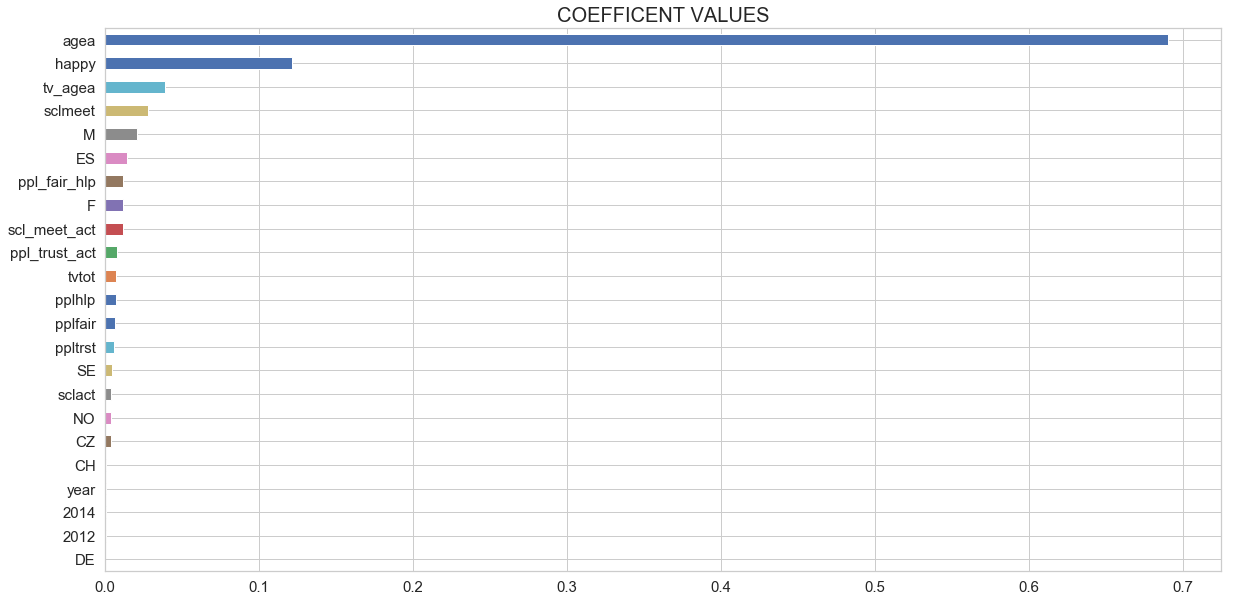

In [163]:
# checking the magnitude of coefficients
sns.set(style="whitegrid")
plt.figure(figsize=(20,10))
predictors = X.columns
plt.title('COEFFICENT VALUES', fontsize=20)
coef = pd.Series(clf.feature_importances_,X.columns).sort_values()
coef.plot(kind='barh',  fontsize=15)

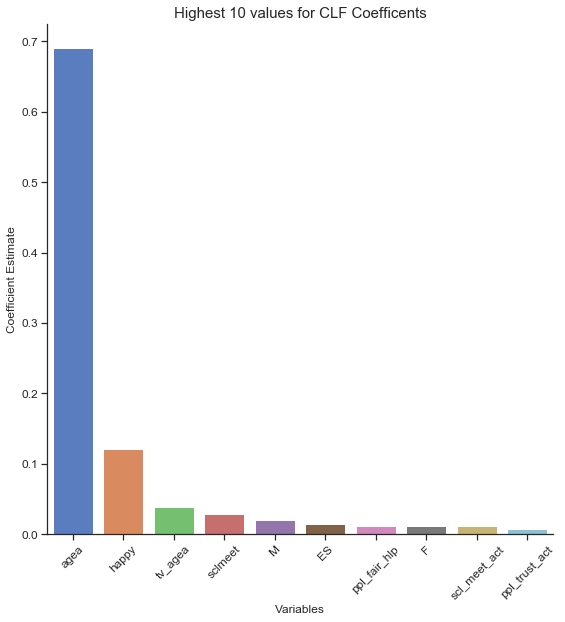

In [164]:
# Highest 10 values for Coefficents
highest = coeff_clf.nlargest(10, 'Coefficient Estimate')

sns.set(style="ticks")

g = sns.catplot(x='Variables', y='Coefficient Estimate', data=highest,
                   height=8, kind="bar", palette="muted", legend=False)
g.set_xlabels(fontsize=12)
g.set_ylabels(fontsize=12)
g.set_xticklabels(rotation=45, fontsize=12)
g.set_yticklabels(fontsize=12)
plt.title('Highest 10 values for CLF Coefficents',fontsize=15)
plt.show()

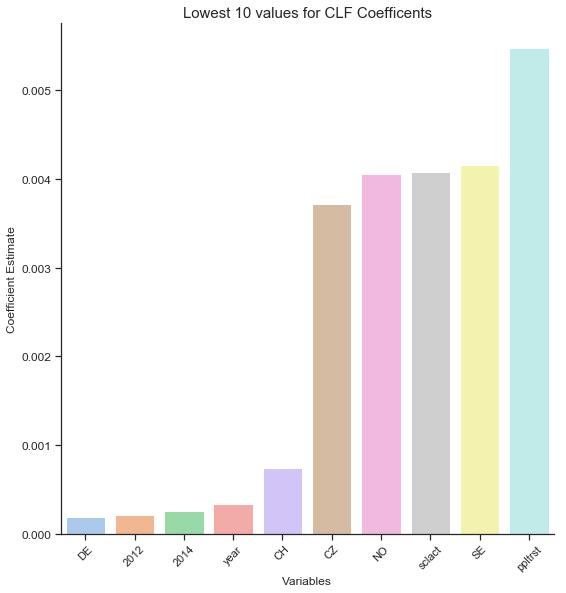

In [165]:
# Lowest 10 values for Coefficents
highest = coeff_clf.nsmallest(10, 'Coefficient Estimate')

sns.set(style="ticks")

g = sns.catplot(x='Variables', y='Coefficient Estimate', data=highest,
                   height=8, kind="bar", palette="pastel", legend=False)
g.set_xlabels(fontsize=12)
g.set_ylabels(fontsize=12)
g.set_xticklabels(rotation=45, fontsize=11)
g.set_yticklabels(fontsize=12)
plt.title('Lowest 10 values for CLF Coefficents',fontsize=15)
plt.show()

In [166]:
# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())

In [167]:
feature_importance.max()

100.0

In [168]:
sorted_idx = np.argsort(feature_importance)

In [169]:
sorted_idx

array([19, 13, 14,  0, 17, 18, 21,  7, 22,  2,  3,  4,  1, 11,  9, 15, 10,
       20, 16,  6, 12,  5,  8], dtype=int64)

In [170]:
pos = np.arange(sorted_idx.shape[0]) + .5

In [171]:
pos

array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
       11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
       22.5])

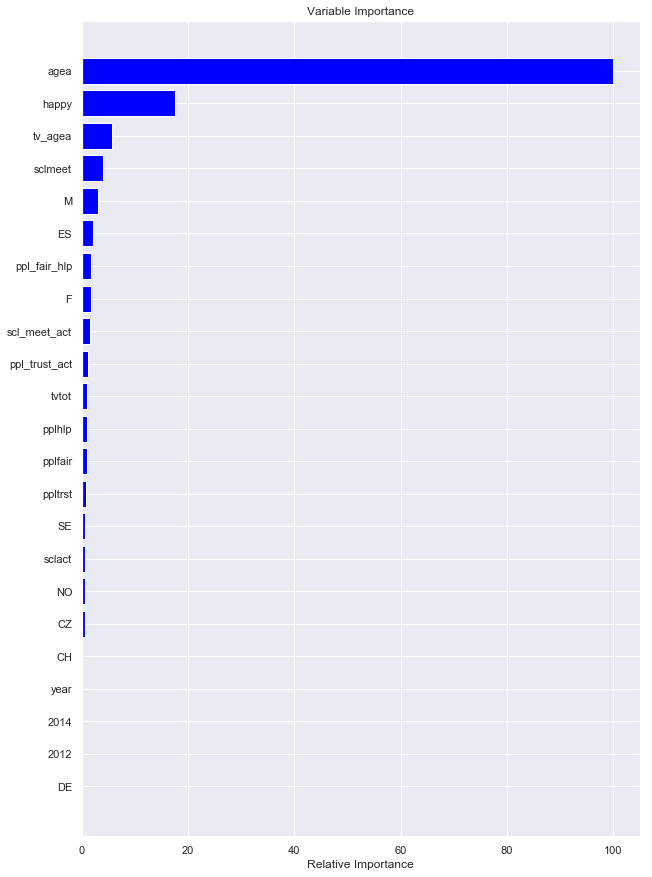

In [172]:
#plt.subplot(1, 2, 2)
import seaborn as sns
sns.set(style="darkgrid")
plt.figure(figsize=(10,15))

plt.barh(pos, feature_importance[sorted_idx], align='center', color='blue')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [173]:
# Classification Report
from sklearn.metrics import classification_report
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.55      0.62      3134
           1       0.75      0.87      0.81      5013

   micro avg       0.74      0.74      0.74      8147
   macro avg       0.74      0.71      0.71      8147
weighted avg       0.74      0.74      0.74      8147



In [ ]:
np.argsort()